In [9]:
#Recap of the code from Cirq

#Number to factorize 
N = 21

#Taking a number x with all the features as mentioned in the theory

import random as rand
import numpy as np

counter = 0

while (True):
    x = rand.randrange(2,N)
    counter += 1
    if np.gcd(x,N) == 1:
        break

print("The number x is: ", x, "at the count of: ", counter)
print()


#Fixing the target qubits

from math import ceil, log2, pi

L = ceil(log2(N))

e = 0.1

t = 2*L + 1 + ceil(log2(2 + 1/2*e))

print("N: ", N)
print("x is: ", x)
print("L :", L)
print("Error: ", e)
print("t: ", t)

import cirq
from cirq import H, SWAP
from cirq.circuits import InsertStrategy
from math import pi
import numpy as np


def opUx(N, x):
    
    k = 1
    while(N > 2**k):
        k = k + 1
    u = np.zeros([2**k, 2**k], dtype = int) 
    for i in range(N):
        u[x*i % N][i] = 1
    for i in range(N, 2**k):
        u[i][i] = 1
    return cirq.MatrixGate(u, name='Ux').controlled()


def myInvQFT(qubits):

    circuit = cirq.Circuit() # create a circuit
    n = len(qubits)
    # swap the qubits
    for j in range(n//2): # integer division
        circuit.append(SWAP.on(qubits[j],qubits[n-j-1]), strategy = InsertStrategy.NEW)
    # inverted phase gates are applied in reverse order and before the hadamard gate
    for i in range(n-1,-1,-1):
        phase_divisor = 2**(n-i)
        for j in range(n-1,i,-1):
            circuit.append(cirq.CZPowGate(exponent = -2/phase_divisor).on(qubits[j],qubits[i]),
                           strategy = InsertStrategy.NEW)
            phase_divisor = phase_divisor / 2
        circuit.append(H(qubits[i]), strategy = InsertStrategy.NEW) # strategy is for the circuit to look neat
    
    return circuit

# Quantum Phase Estimation Algorithm

import cirq
from cirq import X, measure


circuit = cirq.Circuit()

reg1 = [cirq.LineQubit(i) for i in range(t) ]
reg2 = [cirq.LineQubit(i) for i in range(t, t+L) ]

# Apply Hadamard gates to the qubits on the first register
circuit.append(cirq.H.on_each(reg1))

# set the last qubit in second register to |1>
circuit.append(X.on_each(reg2[-1]))

Ux = opUx(N, x)
# apply CU^(2^j) operators
for j in range(t):
    Uxj = Ux**(2**j)
    circuit.append(Uxj(reg1[t-j-1], *reg2))

# the algorithm has been described for the qubit order q0⊗...⊗qt-1
circuit += myInvQFT(reg1)

# Measure
circuit.append(measure(*reg1, key='result'))

# Execute the circuit
sim = cirq.Simulator()
samples = sim.run(circuit, repetitions=1000)



# default representation in Cirq is with decimal numbers
# with this function we convert the decimal numbers into binary (bitstrings)
def bitstring(bits):
    return "".join(str(int(b)) for b in bits)



print("outcomes in binary:")
print(samples.histogram(key='result', fold_func=bitstring))
print()
print("outcomes in decimal:")
outcomes = samples.histogram(key='result')
print(outcomes) # output in decimal form, default in Cirq
print()
for outcome in outcomes:
    print(outcome, "\tobserved", outcomes[outcome], "times")

good = []
for outcome in outcomes:
    if outcome == 0: continue
    if outcomes[outcome] > 10:
        good.append(outcome)
print(good)

#Load the contFrac and convergents functions
quantum_file ="shor.py"
%run $quantum_file

#Run continued fractions algorithm to find out r
for b in good:
    print("for b =",b)
    cf = contFrac(b/(2**t))
    print(cf)
    cv = convergents(cf)
    print(cv)
    print()


#Check if r is even, and x^{r/2} is not equal to -1 Mod N
r = 6  #2
if (r%2==0 and (x**(r/2))%N != -1) :
    print("Proceed")
else:
    print("Repeat the algorithm")



#Compute gcd to find out the factors of N
print("N=",N)
print("x=",x)
print("r=",r)
print("(x**int(r/2)-1)=",(x**int(r/2)-1))
print("(x**int(r/2)+1)=",(x**int(r/2)+1))
print("Factors of",N,":",np.gcd((x**int(r/2)-1),N), "and",np.gcd((x**int(r/2)+1),N))

The number x is:  4 at the count of:  2

N:  21
x is:  4
L : 5
Error:  0.1
t:  13


In [ ]:


import cirq
from cirq import H, SWAP
from cirq.circuits import InsertStrategy
from math import pi
import numpy as np




# Shor's Algorithm using Qiskit

### Writing the whole theory for Shor's Algorithm as a whole

##### FIRST STEP:  Quantum Phase Estimation

It is the process to estimate the phase of a quantum state

Suppose we have a Unitary Operator U, it's eigen state $|u\rangle$ and suppose the eigenvalue is $e^{2\pi i \phi}$, where $\phi$ is the phase of the system. We can define it as:
$$U|u\rangle = e^{2\pi i \phi}|u\rangle$$

Now, we have the following circuit system which we will require to estimate the phase value

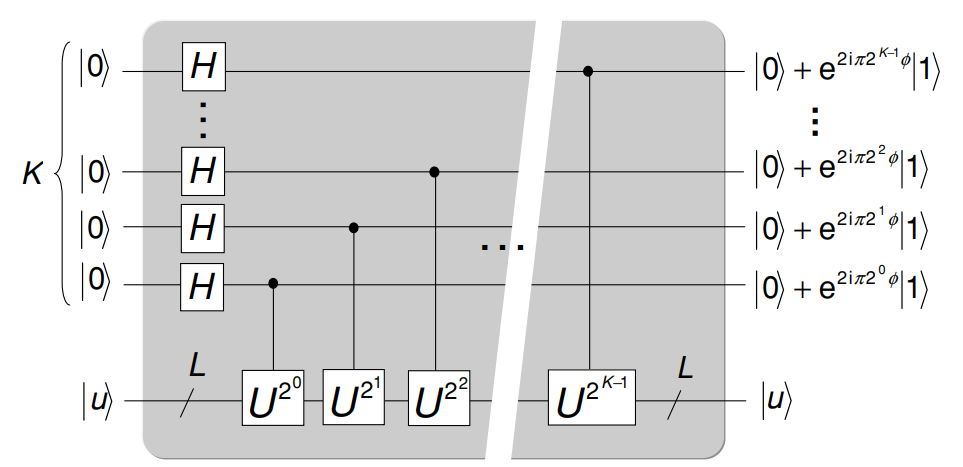

So as input register we have $|0\rangle^{\otimes k}$ of K size and the size of the second register $|u\rangle$ is L. Let's calculate the value of the output registers.

- First The initial state:
$$|0\rangle^{\otimes k}|u\rangle$$
- Second we apply Hadamard to the first K input registers:
$$\frac{1}{2^{k/2}}(|0\rangle+|1\rangle|u\rangle$$
- Third we apply the Controlled Unitary Operator $U^{j}$
(Where, j = $2^0, 2^1, ... ,2^{k-1} $)

The Controlled Unitary only operates when the target qubit is 1
So we get: 
$$CU^{j}[(|0\rangle+|1\rangle \otimes |u\rangle]\\(|0\rangle \otimes |u\rangle) + (|1\rangle \otimes e^{2\pi i \phi j}|u\rangle\\(|0\rangle + e^{2\pi i \phi j} |1\rangle) \otimes |u\rangle$$

We can then write it also as:
$$\frac{1}{2^{k/2}} [(|0\rangle + e^{2\pi i \phi 2^{0}}|1\rangle)(|0\rangle + e^{2\pi i \phi 2^{1}}|1\rangle)...(|0\rangle + e^{2\pi i \phi 2^{k-1}}|1\rangle)] \otimes |u\rangle$$

In compact form we can write it as: (Considering $2^{k} = N$)
$$\frac{1}{\sqrt N}\sum_{k = 0}^{N - 1}e^{2\pi i \phi k}|k\rangle\otimes|u\rangle $$

Let us throw some light on the behaviors of the $\phi$</br>
We can write the real number $\phi = 0.\phi_{1},\phi_{2},...,\phi_{k}$ in the binary form as:  

$\phi = \frac{\phi_{1}}{2}+ \frac{\phi_{2}}{4} + ... + \frac{\phi_{k}}{2^{k}}$

Now, 
$$2^{k- 1}\phi = 2^{k- 1}(\frac{\phi_{1}}{2}+ \frac{\phi_{2}}{4} + ... + \frac{\phi_{k}}{2^{k}})\\
= \{2^{k-2}\phi_{1}+ 2^{k-1}\phi_{2} + ... + 2^{0}\phi_{k-1}\} + ( \frac{\phi_{k}}{2}+ \frac{\phi_{k+1}}{4}+...)$$
and for,
$$2^{k- 2}\phi = 2^{k- 2}(\frac{\phi_{1}}{2}+ \frac{\phi_{2}}{4} + ... + \frac{\phi_{k}}{2^{k}})\\
= \{2^{k-2}\phi_{1}+ 2^{k-3}\phi_{2} + ... + 2^{0}\phi_{k-2}\} + ( \frac{\phi_{k-1}}{2}+ \frac{\phi_{k}}{4}+...)$$

This way we can reduce the exponential integeres as: 
$$e^{2\pi i \phi 2^{k-1}} = 2^{{\pi i}( \frac{\phi_{k}}{2}+ \frac{\phi_{k-1}}{4}+...)}\\e^{2\pi i \phi 2^{k-2}} = 2^{{\pi i}( \frac{\phi_{k-2}}{2}+ \frac{\phi_{k-1}}{4}+...)}\\...\\e^{2\pi i \phi 2^{0}} = 2^{{\pi i}( \frac{\phi_{1}}{2}+ \frac{\phi_{2}}{4}+...)}$$

Now, let us assume that
$$\Omega_{m} = \sum_{l =1}^{m}\frac{\phi_{k- m + l}}{2^{l}}$$

It changes the way we reduced the exponential integers: 

$$e^{2\pi i \phi 2^{k-1}} = e^{2 \pi i \Omega_{1}}( \frac{\phi_{k+1}}{4}+...)\\e^{2\pi i \phi 2^{k-2}} = e^{2 \pi i \Omega_{2}}( \frac{\phi_{k+1}}{8}+...)\\...\\e^{2\pi i \phi 2^{0}} = e^{2 \pi i \Omega_{k}}( \frac{\phi_{k+1}}{2^{k+1}}+...)$$

Now, the thing is we considered only K bits for the input integer because of that reason all the k+1, ...  bits are 0, hence can be ignored and we can thus write the equation:

$$\frac{1}{2^{k/2}} [(|0\rangle + e^{2\pi i \phi 2^{0}}|1\rangle)(|0\rangle + e^{2\pi i \phi 2^{1}}|1\rangle)...(|0\rangle + e^{2\pi i \phi 2^{k-1}}|1\rangle)] \otimes |u\rangle$$
as, 
$$\frac{1}{2^{k/2}} [(|0\rangle + e^{2\pi i \Omega_{1}}|1\rangle)(|0\rangle + e^{2\pi i \Omega_{2}}|1\rangle)...(|0\rangle + e^{2\pi i \Omega_{k}}|1\rangle)] \otimes |u\rangle$$

Now, if we do the Inverse quantum fourier transform in the states, we can recover the state $\phi$ which is the phase of the quantum system
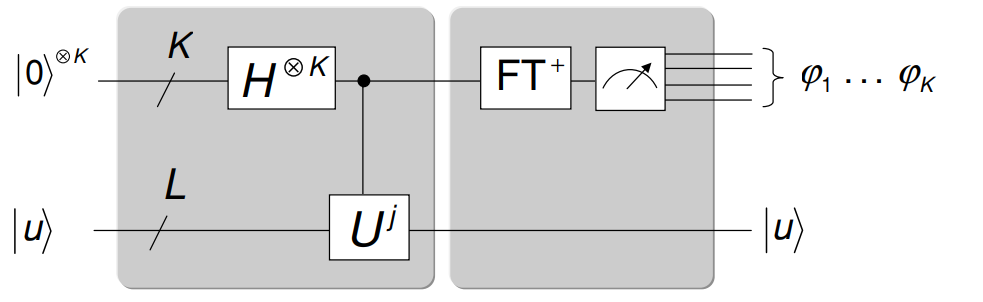

We can thus write the mathematical calculations as the following: 
$$|0\rangle^{\otimes k} |u\rangle \\ \frac{1}{\sqrt N}\sum_{k = 0}^{N-1}e^{2\pi i k \phi}|k\rangle|u\rangle\\\frac{1}{\sqrt N}\sum_{k = 0}^{N-1}e^{2\pi i k \phi}(\frac{1}{2^{k/2}} \sum_{n = 0}^{N-1}e^{\frac{-2\pi i k n}{N}}|n\rangle)|u\rangle\\\\\frac{1}{N}\sum_{n =0}^{N-1}\sum_{k = 0}^{N-1}e^{\frac{-2\pi i k n}{N}}e^{2 \pi i k \phi}|n\rangle|u\rangle\\\frac{1}{N}\sum_{n =0}^{N-1}\frac{1 - e^{2 \pi i (\phi - \frac{n}{N})N}}{1 - e^{2 \pi i (\phi - \frac{n}{N})}}|n\rangle|u\rangle$$
Now, suppose we can to take the measurement in n associated with a probability $P(n)$:

$$P(n) = \frac{1}{N^{2}}\rvert(\frac{1 - e^{2 \pi i (\phi - \frac{n}{N})N}}{1 - e^{2 \pi i (\phi - \frac{n}{N})}})\rvert^{2}\\\frac{1}{N^{2}}\frac{sin^{2}[\pi (\phi - \frac{n}{N})N]}{sin^{2}[\pi (\phi - \frac{n}{N})]}$$

Now the measurement of this gives the value of the probabilistic $\tilde{\phi}$ phase, which is:

$$\tilde{\phi} = \frac{n}{N}$$ 
and the accuracy of it depends on delta when

$$\delta = \phi - \tilde{\phi}$$ 
is minimal
Thus the final out is of the form $|\tilde{\phi}\rangle|u\rangle$

it is theorized that we get the most accurate representation of the phase when we take the following value for the K input registers:

$K = l + \lceil \log_{2}(2+ \frac{1}{2\epsilon})\rceil$ l taken as, $(l = 2L + 1)$ and $L = \lceil(log_{2}N)\rceil$

##### SECOND STEP:  Order Finding



Assume, two positive co-prime numbers x,N; x<N and gcd(x,N) = 1. The order of it will be the smallest integer r for which we will get:

$$x^{r} = 1(\mod N)$$
But how does exactly QPE will solve for the order of this problmem?

Let us take a Unitary Operator $U_{x,N}$ which acts on $|y\rangle = |0\rangle, |1\rangle$ as:
$$U_{x,N}|y\rangle = |x y (\mod N)\rangle$$

For simplicity we consider $U_{x,N} = U$

Consider, $|u\rangle_{s = 0,1,2,...r-1}$ as a set of eigenstates for U for corresponding eigenvalues of the form $e^{\frac{2 \pi i s}{r}}$, thus:

$$U|u\rangle_{s} = e^{\frac{2 \pi i s}{r}}|u\rangle_{s}$$

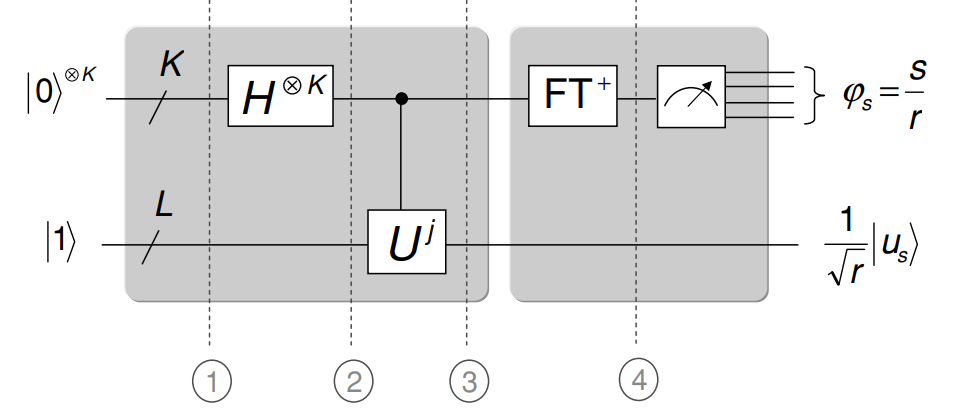


The eigenstates are defined as:

$$|u\rangle_{s} = \frac{1}{\sqrt r}\sum_{s = 0}^{r - 1}e^{-\frac{2\pi i s}{r}}|x^{k}(\mod N)\rangle$$

We can further find out that:
$$\frac{1}{\sqrt r}\sum_{s = 0}^{r - 1}|u_{s}\rangle = |1\rangle$$
This is a good result as we can't define the state $|u\rangle$ without the knowledge of the phase. With this result we need to only define it as a state $|1\rangle$. Morever,
$$\frac{1}{\sqrt r}\sum_{s = 0}^{r - 1}e^{\frac{2\pi i k s}{r}}|u_{s}\rangle = |x^{k}(\mod N)\rangle$$ 

Hence, second register can be given only the state $|1\rangle$ in the $L$ register form 



It is evident to say that, for $j = 2^0, 2^1,...2^{k-1} = 1, ... ,k$:
$$CU^{j}(|0\rangle \otimes |1\rangle) = |1\rangle\\ CU^{j}(|1\rangle \otimes|1\rangle = |x^{j} \mod(N)\rangle$$

Let us define step by step for 1,2,3 and 4:

Step -1: Initialize the states

$$|\psi_{1}\rangle = |0\rangle^{\otimes k}|1\rangle$$

Step - 2: Apply the Hadmard

$$|\psi_{2}\rangle = \frac{1}{\sqrt M}(|0\rangle + |1\rangle)^{\otimes k} |1\rangle = \frac{1}{\sqrt M}\sum_{j = 0}^{M - 1}|j\rangle \otimes |1\rangle$$

Step - 3: Apply the $CU^{j}$ on the second register

$$|\psi_{3}\rangle = \frac{1}{\sqrt M}\sum_{j = 0}^{M - 1}CU^{j}|j\rangle \otimes |1\rangle = \frac{1}{\sqrt{M}}\sum_{j = 0}^{M - 1} |j\rangle|x^{j} (\mod N)\rangle$$

Now, as we know the property:
$$\frac{1}{\sqrt r}\sum_{s = 0}^{r - 1}e^{\frac{2\pi i k s}{r}}|u_{s}\rangle = |x^{k}(\mod N)\rangle$$ 

We will do this, 
$$|\psi_{3}\rangle = \frac{1}{\sqrt M}\sum_{k = 0}^{M-1}|k\rangle \otimes \frac{1}{\sqrt{r}}\sum_{s = 0}^{r - 1}e^{\frac{2\pi i k s}{r}}|u_{s}\rangle$$

Now taking $\phi_{s} = \frac{s}{r}$ and changing the $|j\rangle$ basis to $|k\rangle$

$$|\psi_{3}\rangle = \sum_{s= 0}^{r - 1}(\frac{1}{\sqrt M} \sum_{k = 0}^{M-1}e^{2\pi i k \phi_{s}}|j\rangle)\otimes \frac{1}{\sqrt r}|u_{s}\rangle$$

Step -4: Performing Inverse Fourier Transform we can get the approximation of the eigenstate of the $\tilde{\phi}$, as before the measurement we have the state:

$$|\psi_{4}\rangle = \frac{1}{\sqrt r}\sum_{s =0}^{r-1}{|\tilde{\phi_{s}}\rangle}\otimes |u_{s}\rangle$$

Thus, finally we get the approximation $\tilde{\phi_{s}} \approx \phi  = \frac{s}{r}$

Now, from the post processing we attain the value of r using the fact that $\frac{s}{r}<1$

1- Randomly choose $x \in [2, N-2]$

   Calculate $\text{GCD}(x, N)$, and if $> 1$, redo

2- Find $r$, the order of $x$ modulo $N$

   > Make measurement of quantum phase $\tilde{\varphi} = s'/r'$

   > Get $r$ through the continued fraction expansion of $\tilde{\varphi}$

   > Check that $x^r = 1 \mod N$, and if not, redo

   > Check that $r$ is even and $x^{r/2} \neq -1 \mod N$, if not go to 1

3- Calculate $N' = \text{GCD}(y + 1, N)$, $N'' = \text{GCD}(y - 1, N)$

4- Factorize $N', N''$ (as applicable)


Step by step process to generate the code:

In [1]:
# #Randomly choose the value of x for the N

# """
# Some things to keep in mind
# - x<N ; gcd(x, N) = 1 if not then choose another x as the current one already a factor of N
# """

#Number to factorize 
N = 221

# #Taking a number x with all the features as mentioned in the theory
import random as rand
import numpy as np

# counter = 0

# while (True):
#     x = rand.randrange(2,N)
#     counter += 1
#     if np.gcd(x,N) == 1:
#         break

# print("The number x is: ", x, "at the count of: ", counter)
# print()


# #Fixing the target qubits

# from math import ceil, log2, pi

# L = ceil(log2(N))

# e = 0.1

# t = 2*L + 1 + ceil(log2(2 + 1/2*e))

# print("N: ", N)
# print("x is: ", x)
# print("L :", L)
# print("Error: ", e)
# print("t: ", t)


counter = 0
while True:
    a = rand.randrange(2,N) 
    counter += 1
    if np.gcd(a,N) == 1:
        break
    
    # Define the value of "a" that will be used to implement the Shor's algorithm

print("Value of N =",N)
print("Value of a =",a)



#imports for the program
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import QFT
from qiskit_aer.primitives import Sampler
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.visualization import plot_histogram
import math

#Calculating the binary representation of an integer

def toBinary(val):
    binary = ''
    loop = val

    while loop> 0:
        temp = loop % 2
        loop = loop // 2
        binary += str(temp)

    binary = binary[::-1]
    return binary


#Translate Binary to Integer

def toInteger(val: str): 

    num = 0
    val = val[::-1]

    for i in range(len(val)):
        if val[i] == '0':
            continue

        else:
            num += 2**i
    return num


#Implementing the Unitary Gate
def opUx(a, power, N):
    to_binary = toBinary(N) # Generate the binary representation of the test number "N"
    n = len(to_binary)      # From the binary representation, we can determine the number of bits needed to build the circuit

    circuit = QuantumCircuit(n) # Create a new circuit
    
    for i in range(power):
        for j in range(n-1, 0, -1):
            circuit.swap(j-1, j)     # Swap all the gates linearly
        for j in range(n):
            circuit.x(j)             # Apply an x gate to all the qubits
    
    circuit.name = f'{a}^{power} mod {N}' # Rename the circuit based on the test value and the current power
    # display(circuit.draw('mpl'))
    circuit = circuit.to_gate()
    c_circuit = circuit.control()
    return c_circuit    

Value of N = 221
Value of a = 158


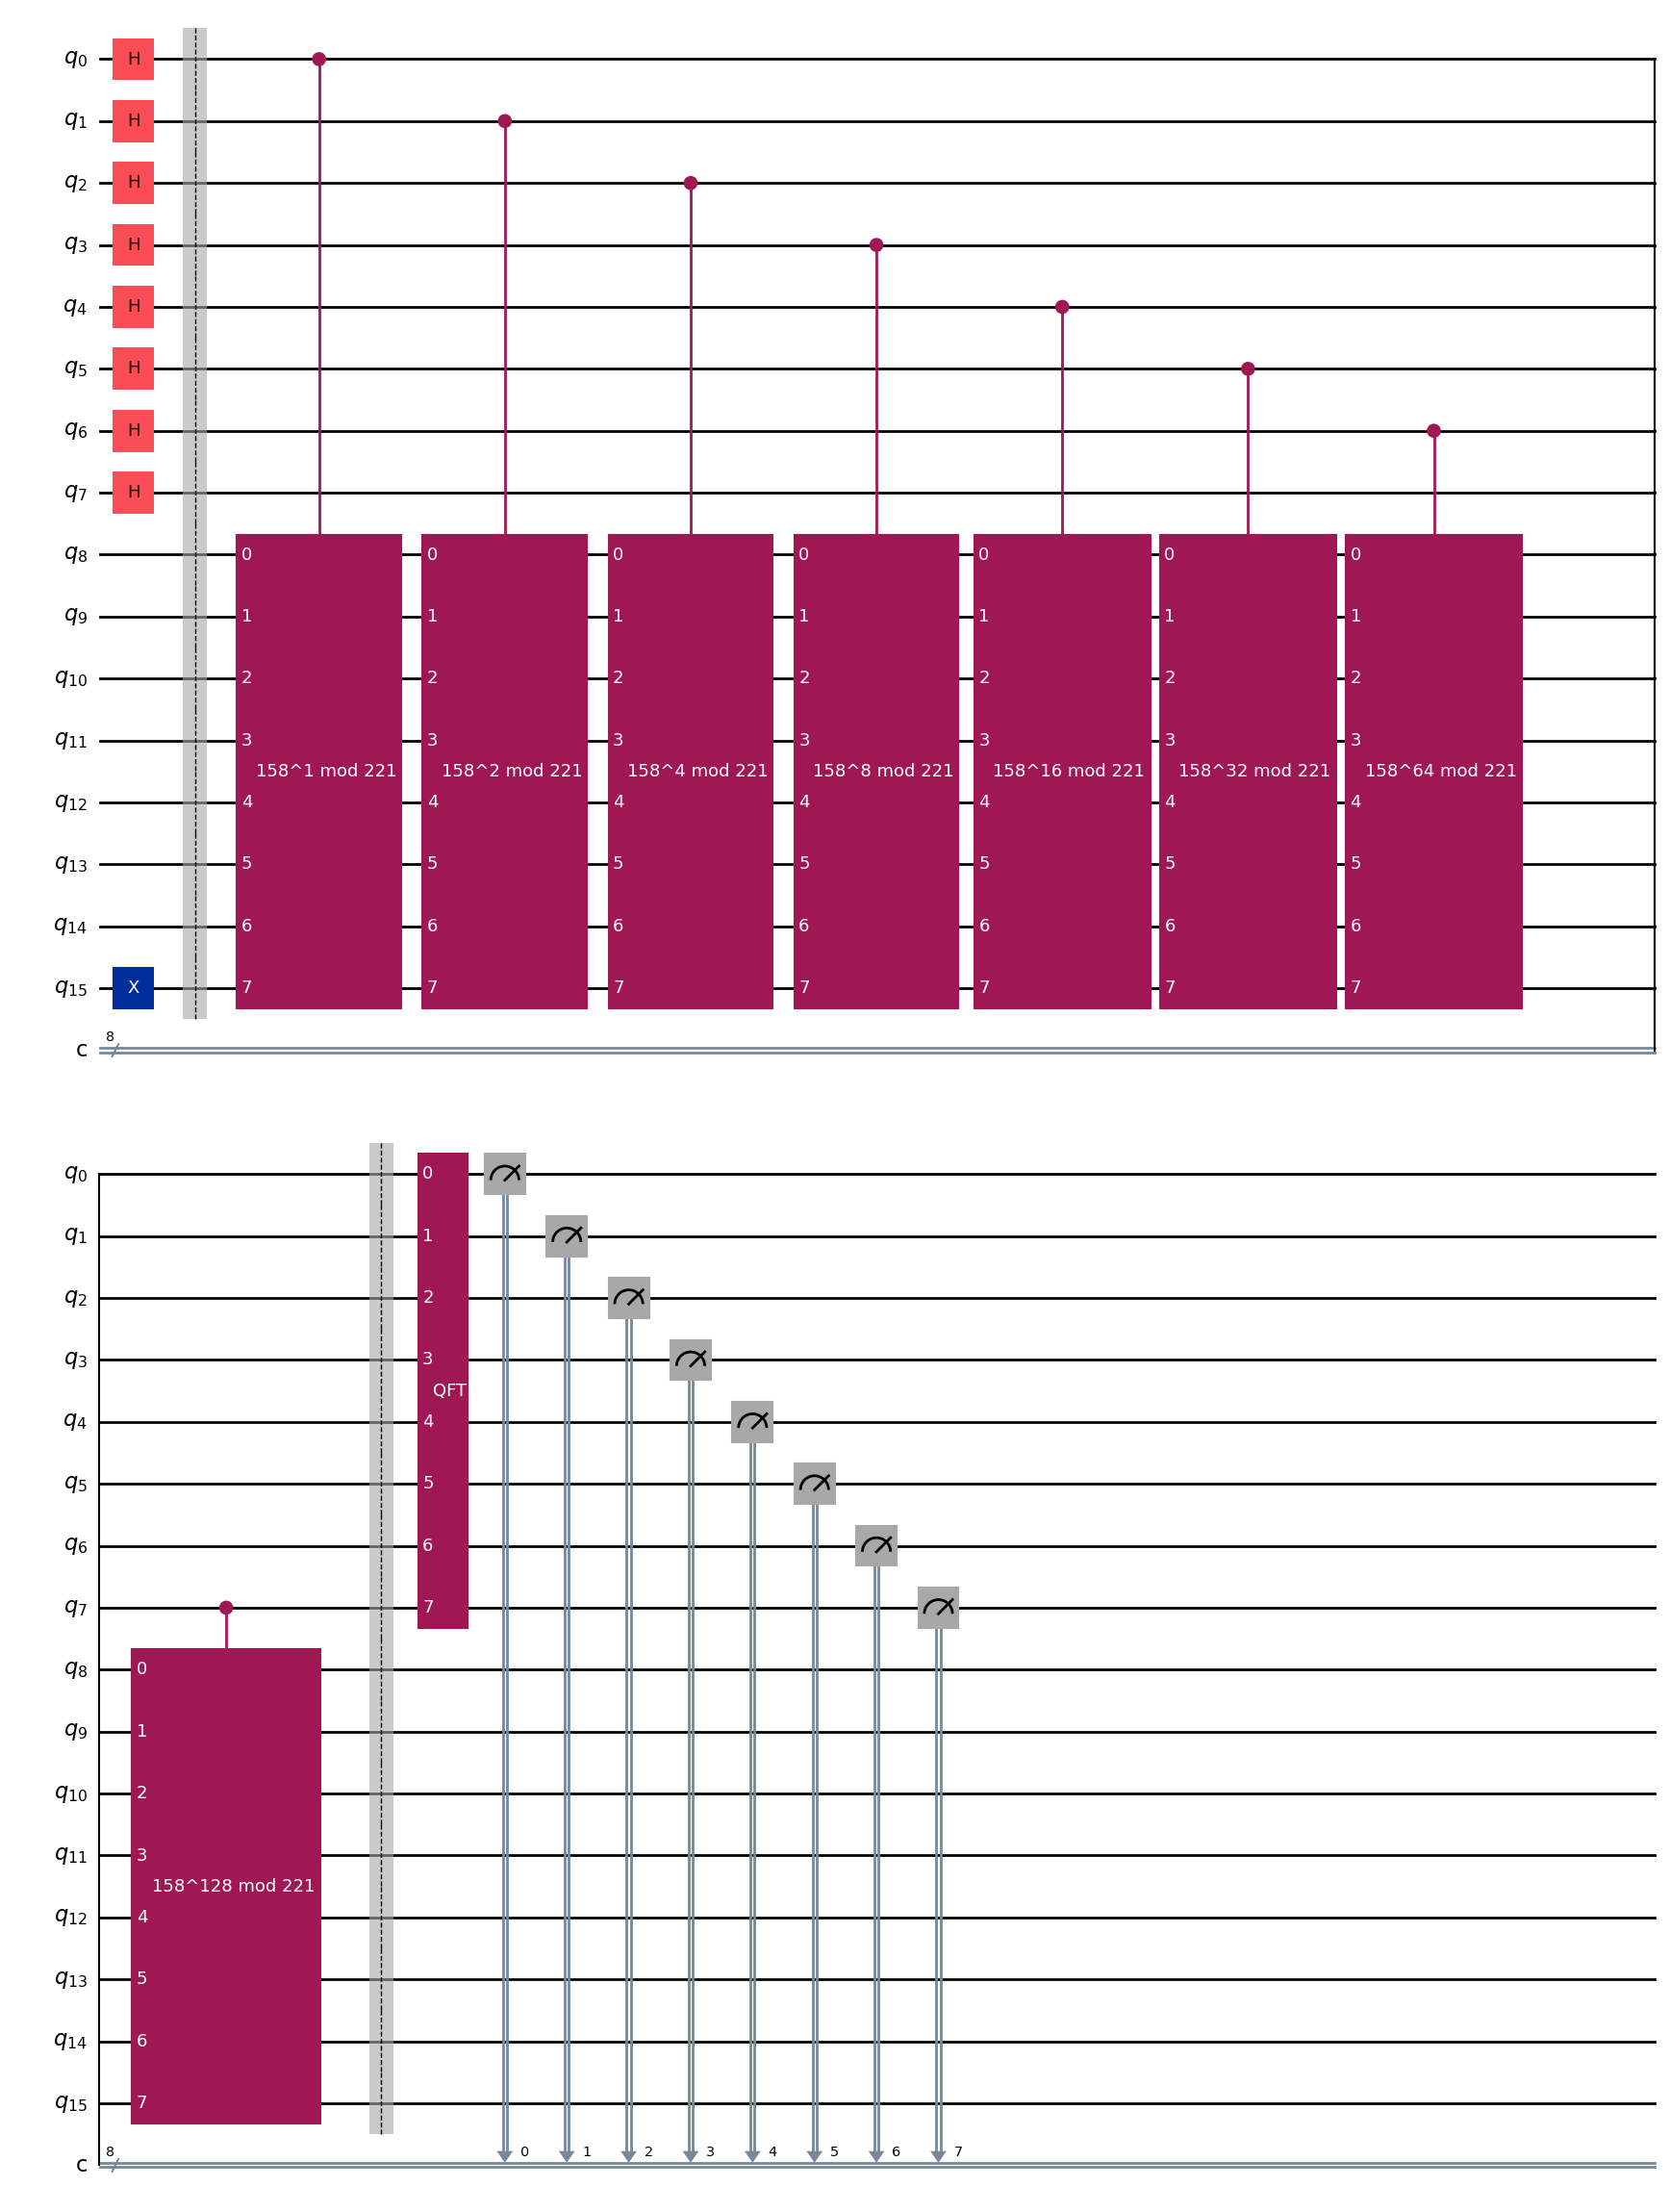

In [2]:
N_binary = toBinary(N) # Generate the binary representation of the number so that we can generate the number of qubits needed.
n = len(N_binary) 
m = 2 * n

circuit = QuantumCircuit(m, n)

# apply the hadamard gate to the input value
for i in range(n):
    circuit.h(i)

# Helper x gate
circuit.x(m-1)
circuit.barrier()

# Modify the circuit so that we can install the Controll-ROT gate.
# opUx implements an instance of the UROT gate per each power basis, 
# and the following loop tells the c_amodN gate which qubits it can 
# apply to.

for i in range(n):
    circuit.append(opUx(a, 2**i, N), [i]+[j+n for j in range(m-n)])

circuit.barrier()

qft = QFT(n)
qft.inverse()
circuit.append(qft, range(n))

circuit.measure(range(n), range(n))
display(circuit.draw('mpl'))

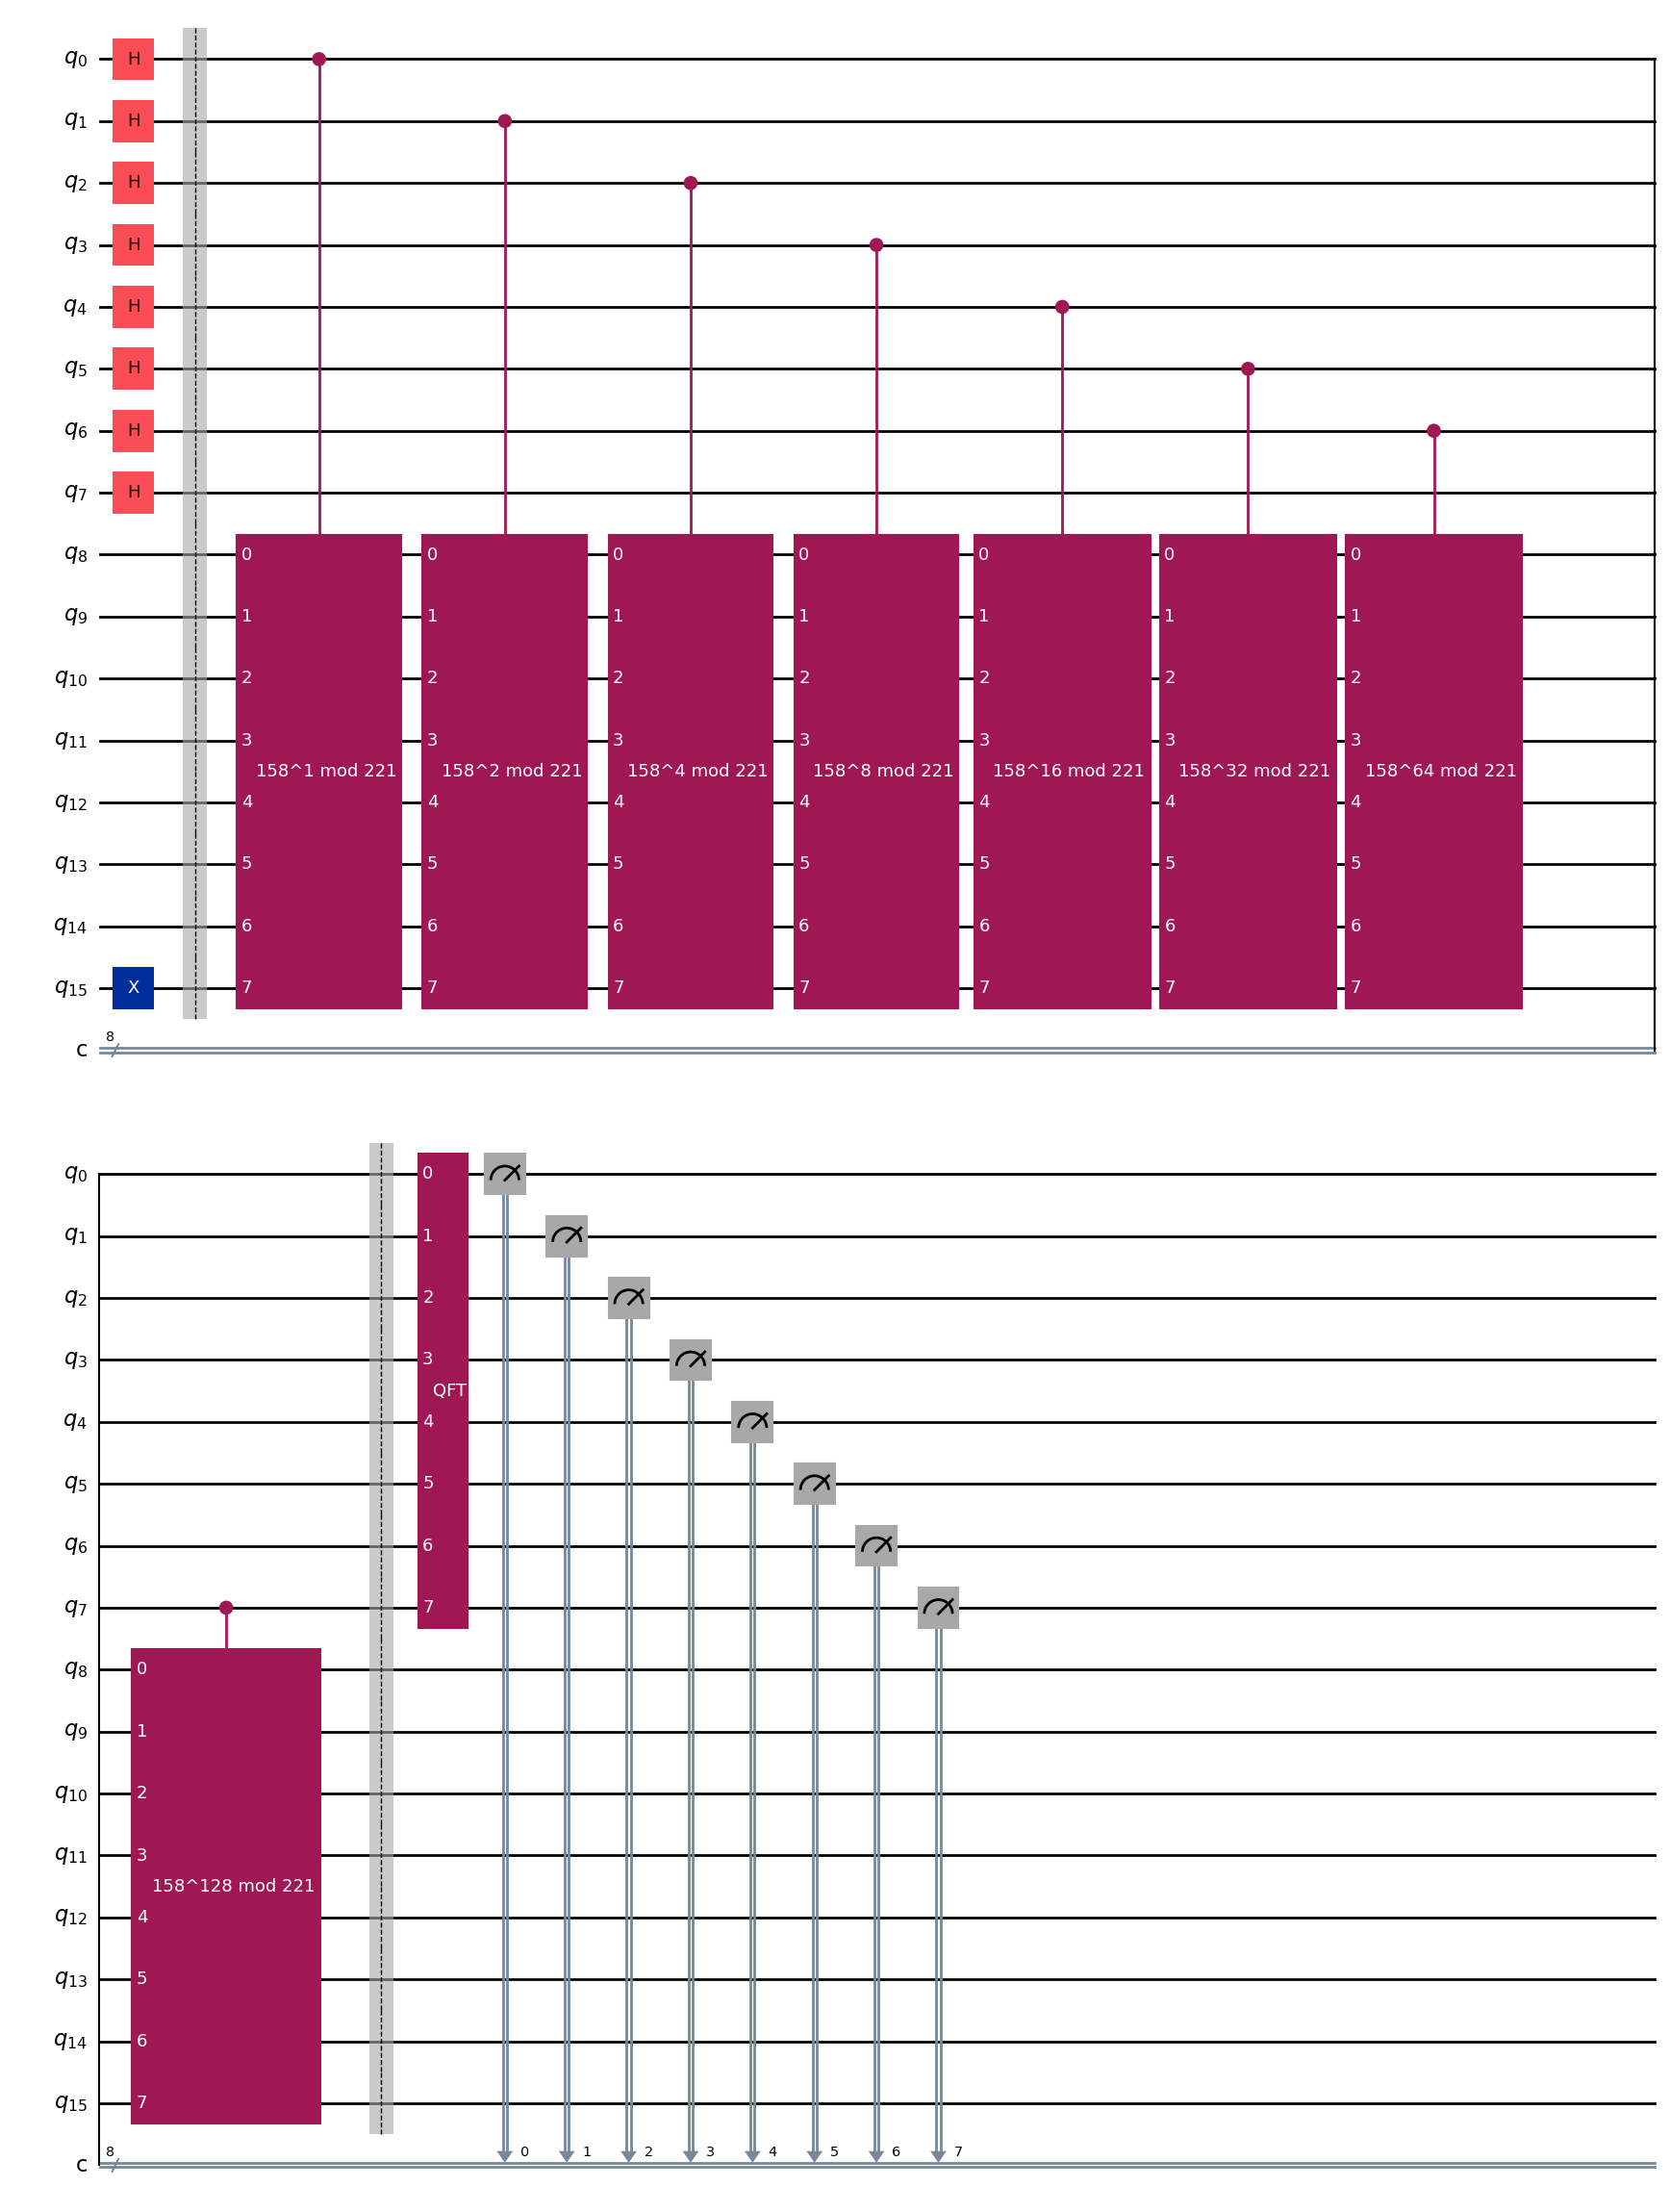

In [3]:
#The Shor's Circuit

N_binary = toBinary(N) # Generate the binary representation of the number so that we can generate the number of qubits needed.
n = len(N_binary) 
m = 2 * n

circuit = QuantumCircuit(m, n)

# apply the hadamard gate to the input value
for i in range(n):
    circuit.h(i)

# Helper x gate
circuit.x(m-1)
circuit.barrier()

# Modify the circuit so that we can install the Controll-ROT gate.
# c_amodN implements an instance of the UROT gate per each power basis, 
# and the following loop tells the c_amodN gate which qubits it can 
# apply to.

for i in range(n):
    circuit.append(opUx(a, 2**i, N), [i]+[j+n for j in range(m-n)])

circuit.barrier()

qft = QFT(n)
qft.inverse()
circuit.append(qft, range(n))

circuit.measure(range(n), range(n))
display(circuit.draw('mpl'))

In [4]:
# Simulation using the sampler class.
def samplerSimulator(circuit):
    sampler = Sampler()
    results = sampler.run(circuit).result() # create a simulator to test the circuit and get the results from it.
    probabilities = results.quasi_dists # separate the probability of the values 
    return probabilities

# Secondary simulator using the BasicSimulator() class
def basicSimulator(circuit):
    backend = BasicSimulator()
    tqc = transpile(circuit, backend)
    counts = backend.run(tqc).result().get_counts()
    return counts

[{32: 0.1259765625, 0: 0.1162109375, 160: 0.126953125, 128: 0.1259765625, 96: 0.1220703125, 192: 0.1435546875, 224: 0.130859375, 64: 0.1083984375}]


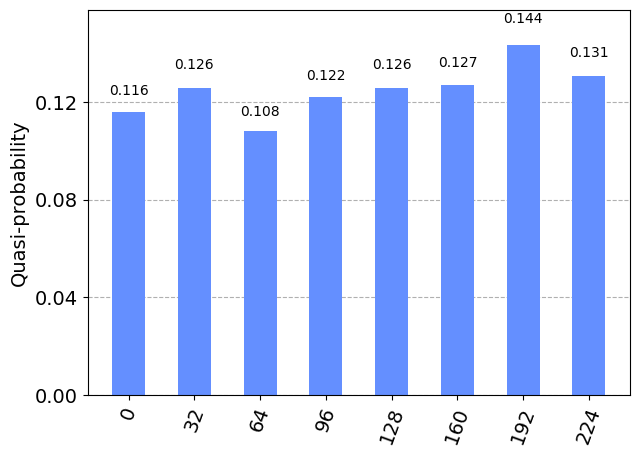

In [5]:
probabilities = samplerSimulator(circuit)
print(probabilities)

display(plot_histogram(probabilities))

In [6]:
def getResultsList(probabilities):
    results_list = []
    for key in probabilities:     # unpack the map
        for j in key:      # get all the measured vectors
            if j == 0:     # if the output is 0, we can discard it since it is not usefult as a period guesser
                continue
            else:
                results_list.append(j)
    return results_list

In [7]:
def printPQ(p, q):

    # The circuit implementation of Shor's algorithm cannot find a value for "p" and "q" if the value of "a"
    # from the start is a factor of the vale "N", thus we can inform the tester about it here
    if N % a == 0: 
        p = a
        q = N // a
        print("The value you chose for \"a\" is a factor of \"N\"!")
        print("N =",N)
        print("Prime Factor 1 =",p)
        print("Prime Factor 2 =",q)

    else:
        if p != 0:             # given a value p that is not 0/1, we can find the other value of q, since N = p * q => q = N / p
            q = N // p
        elif q != 0:           # given a value q that is not 0/1, we can find the other value of p, since N = p * q => p = N / q
            p = N // q

        if p == 0 and q == 0:  # if both p and q are 0, that means that we don't have propper factors, thus search for another value for "a"
            print("Try a different value for \"a\"!")
        else:
            print("N =",N)
            print("Prime Factor 1 =",p)
            print("Prime Factor 2 =",q)

In [8]:
# i. Extract the list of possible periods "r" from the results of the Quantum Simulation
r_options = getResultsList(probabilities)

print("Periodicity from the circuit =>",r_options)

# Find the values for the factors "p" and "q"
p = 0
q = 0
for i in r_options:
    if i % 2 == 0:
        x = (a**(i//2)) % N # Compute the periodicity check by applying modulus arithmetic.
        temp_p = math.gcd(x-1, N) # Find the GCD between the value of x-1 and N
        temp_q = math.gcd(x+1, N) # Find the GCD between the value of x+1 and N

        # if the values of temp_p and temp_q are 1 or N, then we need to check for other
        # values since they are not our key answers
        if temp_p != 1 and temp_p != N: 
            p = temp_p
        if temp_q != 1 and temp_q != N:
            q = temp_q 
        else:
            continue
    else:
        continue

Periodicity from the circuit => [224, 192, 32, 64, 160, 96, 128]


In [9]:
printPQ(p, q)

N = 221
Prime Factor 1 = 17
Prime Factor 2 = 13


{'10000000': 127, '01000000': 126, '00000000': 101, '11100000': 133, '10100000': 122, '11000000': 144, '01100000': 128, '00100000': 143}


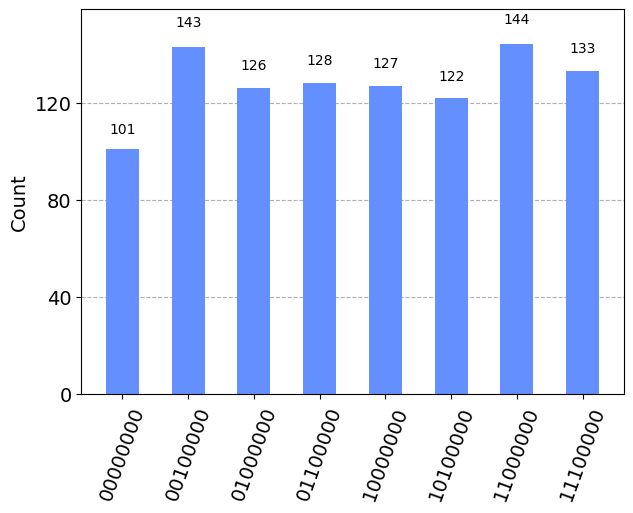

In [10]:
counts = basicSimulator(circuit)
print(counts)

keys = []
for i in counts:
    keys.append(i)

display(plot_histogram(counts))

In [11]:
r_candidates = []
for i in keys:
    if toInteger(i) == 0:
        continue
    else:
        r_candidates.append(toInteger(i))

p = 0
q = 0
for i in r_candidates:
    if i % 2 == 0:
        x = (a**(i//2)) % N
        temp_p = math.gcd(x-1, N)
        temp_q = math.gcd(x+1, N)
        
        if temp_p != 1 and temp_p != N:
            p = temp_p
        if temp_q != 1 and temp_q != N:
            q = temp_q 
        else:
            continue
    else:
        continue

printPQ(p, q)

N = 221
Prime Factor 1 = 17
Prime Factor 2 = 13


In [6]:
print(circuit.depth())
print()
print(circuit.width())
print()

11

24

